Dataset: Motion Capture Hand Postures Dataset from UCI Machine Learning Repository.

In [1]:
# https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures

Data Pre-processing: 

In [2]:
#Data Pre-processing:
#all markers were transformed to the local coordinate system of the record containing them
#each transformed marker with a norm > 200mm was pruned
#Any record contianing less than 3 markers was removed
#the processed data has at most 12 markers per record and at least 3

Other useful information about the dataset:

In [3]:
#Other General info about Data
#12 users, 5 hand gestures, with markets attached to left-handed glove
#3 markers attached to thumb on nail and knuckles
#2 markers on each finger, one above fingernail, other on the joing between the proximal and middle phalanx

#The 11 markers not part of the rigid pattern were unlabled; their positions were not explicitly tracked.
#Consequently, there is no a priori correspondence between the markers of two given records. 


#Other Provided information: 
#Due to the manner in which data was captured, its likely that for a given record and user there exists
#a near duplicate record originating from the same user. We reccomend therefore to evaluate classification
#algorithms on a leave-one-user-out basis wherein each user is iteratively left out from training and used as a test set. 


Importing Dependencies

In [4]:
#necessities
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#data transformation and evaluation
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from scipy import stats
from scipy.stats.mstats import winsorize
import re
import math
import statistics


#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

#%matplotlib inline
#%matplotlib notebook

Data cleaning basics

In [5]:
#importing data
df = pd.read_csv('postures.csv')

#dropping empty category (accoding to data author)
df.drop(df[df['User'] == 0].index, inplace=True)

#replacing questionmarks 
df = df.replace('?', np.NaN)

#converting data type
df = df.astype(float)

#dropping X11, Y11, Z11 because they are near empty
df.drop(['X11', 'Y11', 'Z11'], axis=1, inplace=True)

#saving copy of formatted dataframe
df_cpy = df.copy()

#examining the shape of the data
df.shape

(69047, 35)

Here we will scale the data to prevent negative coordinate values from impacting our calculations, visualizations and models later. 

In [6]:
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
9049,1.0,1.0,29.699315,86.235155,-50.412865,10.640074,84.263077,-44.484302,53.356216,82.914148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,1.0,1.0,29.744358,85.954124,-50.094668,10.739796,84.043944,-44.134900,53.374626,82.571797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,1.0,1.0,29.713936,85.950764,-49.606704,10.628119,84.095152,-43.928478,53.496711,82.573430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,1.0,1.0,29.712018,85.967603,-49.239333,10.550590,84.123348,-43.922002,53.672679,82.547662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9053,1.0,1.0,30.430470,85.626083,-48.860555,10.997782,84.049843,-44.259520,54.588424,82.366638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#renaming numerical classes to represent their gesture 

rename = ['Thumb_up', 'Stop', 'Point', 'Peace', 'Grab']
class_number = 1

for name in rename:
    df.loc[df['Class'] == class_number, 'Class'] = rename[class_number-1]
    class_number +=1

In [8]:
#shifting coordinates into positive plane by adding smallest value to all coordinate values
coord_cols = df.columns[2:]

for i in coord_cols:
    df[i] = df[i] + 168
    
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
9049,Thumb_up,1.0,197.699315,254.235155,117.587135,178.640074,252.263077,123.515698,221.356216,250.914148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,Thumb_up,1.0,197.744358,253.954124,117.905332,178.739796,252.043944,123.865100,221.374626,250.571797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,Thumb_up,1.0,197.713936,253.950764,118.393296,178.628119,252.095152,124.071522,221.496711,250.573430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,Thumb_up,1.0,197.712018,253.967603,118.760667,178.550590,252.123348,124.077998,221.672679,250.547662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9053,Thumb_up,1.0,198.430470,253.626083,119.139445,178.997782,252.049843,123.740480,222.588424,250.366638,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#log transforming data to handle outliers
df = pd.concat([df[df.columns[:2]], np.log(df[df.columns[2:]])], axis=1)

df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10
9049,Thumb_up,1.0,5.286747,5.538260,4.767180,5.185373,5.530472,4.816368,5.399773,5.525111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9050,Thumb_up,1.0,5.286975,5.537154,4.769882,5.185931,5.529603,4.819193,5.399856,5.523745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9051,Thumb_up,1.0,5.286821,5.537140,4.774012,5.185306,5.529807,4.820858,5.400408,5.523752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9052,Thumb_up,1.0,5.286812,5.537207,4.777110,5.184872,5.529918,4.820910,5.401202,5.523649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9053,Thumb_up,1.0,5.290439,5.535861,4.780295,5.187373,5.529627,4.818186,5.405324,5.522926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


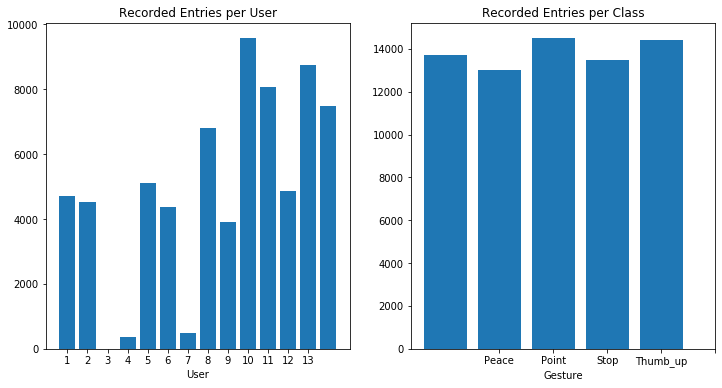

User Counts
User
1.0     4717
2.0     4513
4.0      379
5.0     5105
6.0     4377
7.0      492
8.0     6811
9.0     3920
10.0    9573
11.0    8061
12.0    4865
13.0    8739
14.0    7495
Name: Class, dtype: int64
---------
Class Counts
Class
Grab        13690
Peace       12994
Point       14493
Stop        13477
Thumb_up    14393
Name: User, dtype: int64


In [10]:
#Counting the available data for each user (because pointers can change between users)
user_count = df.groupby('User').agg('count')['Class']

#Counting the available data for each hand gesture
class_count = df.groupby('Class').agg('count')['User']

#Plotting bar graph to compare recorded entries per user
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(user_count.index, user_count)
plt.title('Recorded Entries per User')
plt.xlabel('User')
plt.xticks(np.arange(1,14, step=1))

#Plotting bar graph to compare amount of entries per class 
plt.subplot(1,2,2)
plt.bar(class_count.index, class_count)
plt.title('Recorded Entries per Class')
plt.xlabel('Gesture')
plt.xticks(np.arange(1,6, step=1))
plt.show()

print('User Counts')
print(user_count)
print('---------')
print('Class Counts')
print(class_count)

To start exploring our data we can use boxenplots to examine how the distribution of our data changes based on the gesture that is being made. We can do this any compare every coordinate channel to see that there are notable differences between every gesture. The plots below serve only to show that there is a clear difference between each gesture that can be used to help us classify new gestures after training based on some of these differences. 

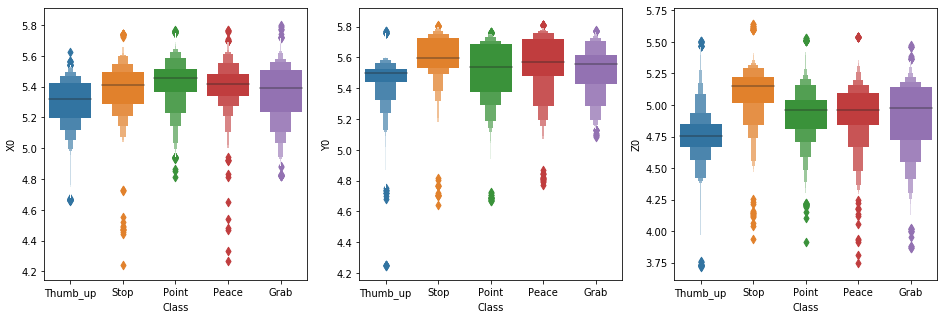

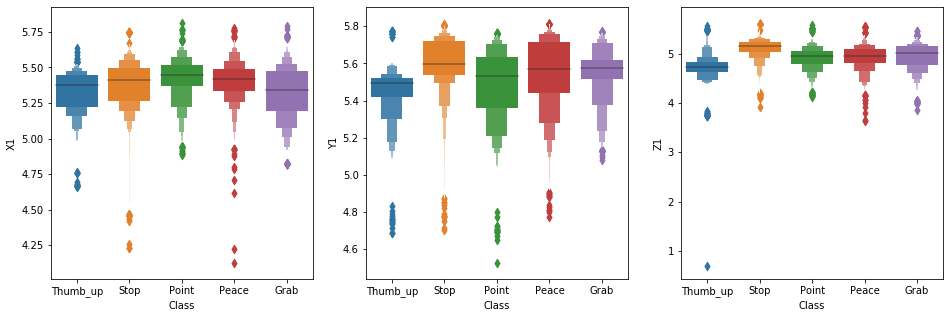

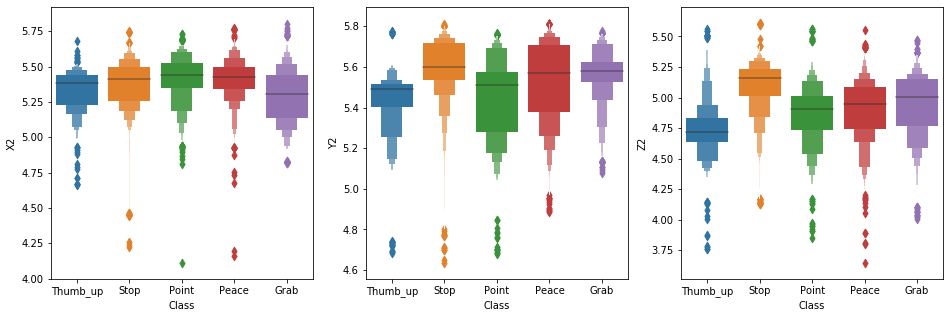

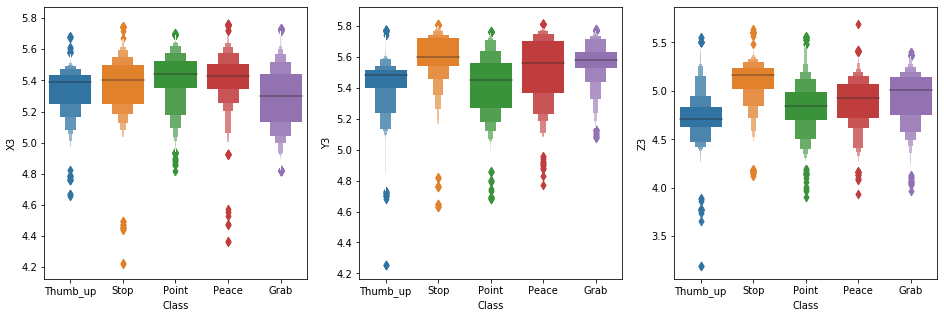

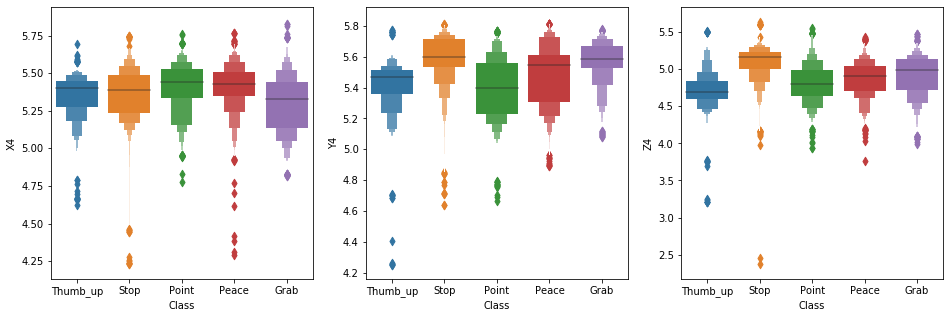

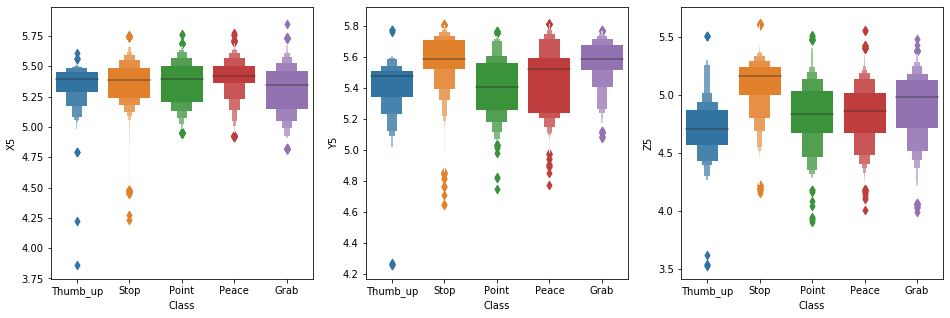

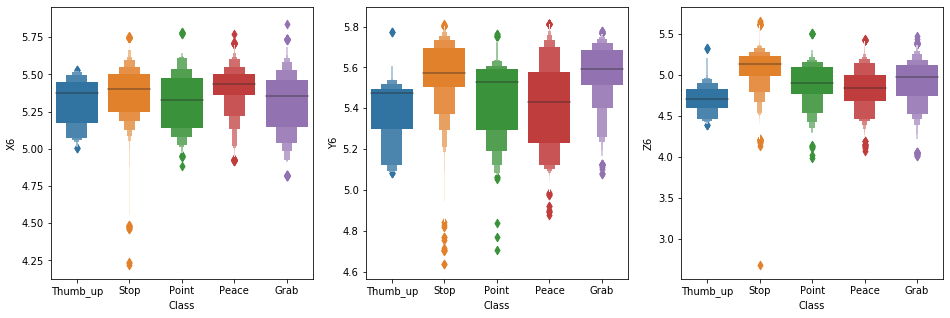

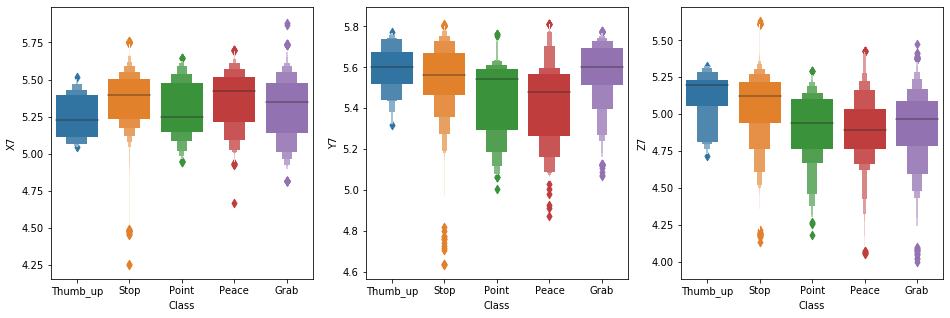

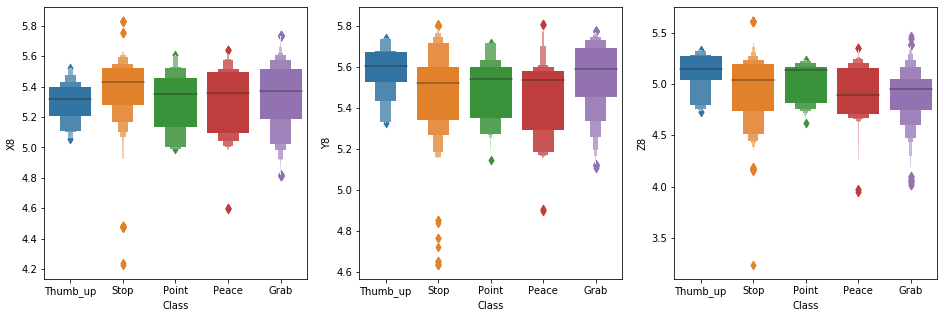

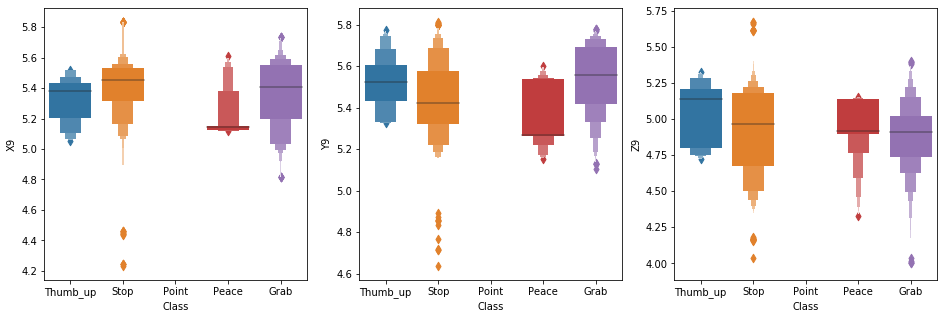

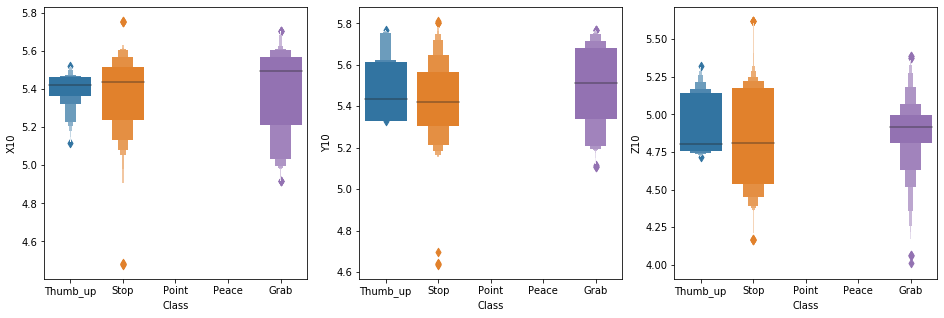

In [11]:
for i in range(11):
    plt.figure(figsize=(16,5))
    plt.subplot(1,3,1)
    sns.boxenplot(x='Class', y='X'+str(i), data=df)
    plt.subplot(1,3,2)
    sns.boxenplot(x='Class', y='Y'+str(i), data=df)
    plt.subplot(1,3,3)
    sns.boxenplot(x='Class', y='Z'+str(i), data=df)
    plt.show()

In [12]:
col_names = list(df.columns)
col_names.remove('Class')
col_names.remove('User')

#Order column names by their coordinate term
col_names.sort()

x_terms = col_names[0:11]
y_terms = col_names[11:22]
z_terms = col_names[22:33]

In [13]:
class_1 = df[df['Class'] == 'Thumb_up']
class_2 = df[df['Class'] == 'Stop']
class_3 = df[df['Class'] == 'Point']
class_4 = df[df['Class'] == 'Peace']
class_5 = df[df['Class'] == 'Grab']

gestures = [class_1, class_2, class_3, class_4, class_5]

Below we can examine the mean of the X, Y and Z values for each gesture (class) in the form of a KDE curve. In the plots below we have scaled each curve and placed them on an equivalent scale. This allows us to compare the unique features of each gesture. We can see that the shape, location and magnitude of each kde plot is unique and though gestures may be similar there are no two identical fingerprints found below. 

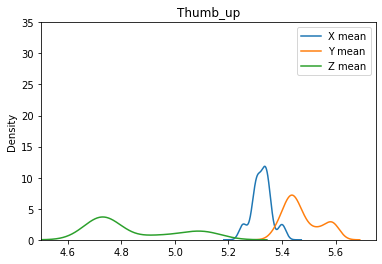

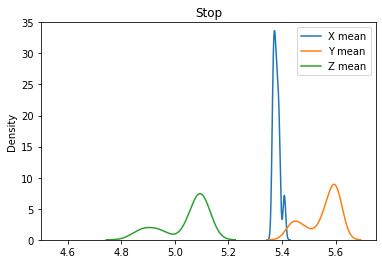

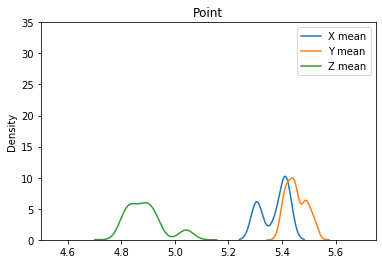

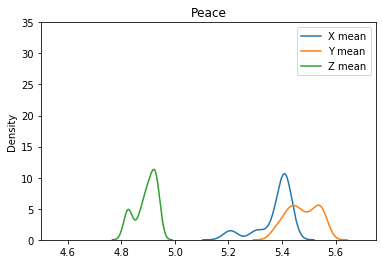

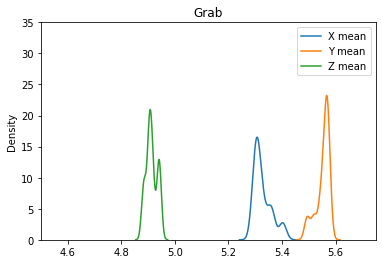

In [14]:
#calculate and examine the distribution of mean values for the coordinates
title = 0

for g in gestures:
    g[x_terms].mean().plot.kde(bw_method=.4)
    g[y_terms].mean().plot.kde(bw_method=.4)
    g[z_terms].mean().plot.kde(bw_method=.4)
    plt.legend(['X mean', 'Y mean', 'Z mean'])
    plt.ylim(0, 35)
    plt.xlim(4.5, 5.75)
    plt.title(rename[title])
    title +=1
    plt.show()

We were able to make the plots by first grouping our data by the gesture that it was collected for, next within those groups we calculated the means for each of the 30 datapoints (X0...X10, Y0...Y10, Z0...Z10). Once we had those means we had a general understanding of how the position of a person's hand tended to change, with respect to each coordinate X, Y and Z. We can plot these kernal density estimations for each coordinate (X,Y,Z) grouped by gesture to see how each of our gestures differs from the rest. We can see from the above graphs that each gesture has a unique density profile. We see that some gestures share similarities with others but each has a unique fingerprint that shows that we have clear and meaningful differences between our gesture data that can help us to classify a gesture that we are fed information about. 

We can see that the shapes can look pretty similar but scales may differ. We can examine the same data below, instead comparing how the shape of the curve that each class carves in the given coordinate system. 

In [15]:
#grouping data by class and term
x_means = df.groupby(by='Class').mean()[x_terms]
y_means = df.groupby(by='Class').mean()[y_terms]
z_means = df.groupby(by='Class').mean()[z_terms]

In [16]:
#reindexing data for plotting
x_df = x_means.T.reindex(['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
y_df = y_means.T.reindex(['Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10'])
z_df = z_means.T.reindex(['Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10'])

x_df

Class,Grab,Peace,Point,Stop,Thumb_up
X0,5.354331,5.408438,5.422247,5.390028,5.304916
X1,5.320665,5.407467,5.421486,5.380123,5.331604
X2,5.298556,5.410129,5.411367,5.377593,5.334438
X3,5.294898,5.415178,5.408713,5.373703,5.337986
X4,5.302398,5.413860,5.402514,5.365374,5.349395
X5,5.310387,5.411304,5.370956,5.367103,5.349003
X6,5.310585,5.408871,5.314045,5.372579,5.306696
X7,5.307000,5.367585,5.302522,5.368815,5.254939
X8,5.332363,5.305722,5.301408,5.388529,5.294447
X9,5.364333,5.207718,NaN,5.408661,5.312261


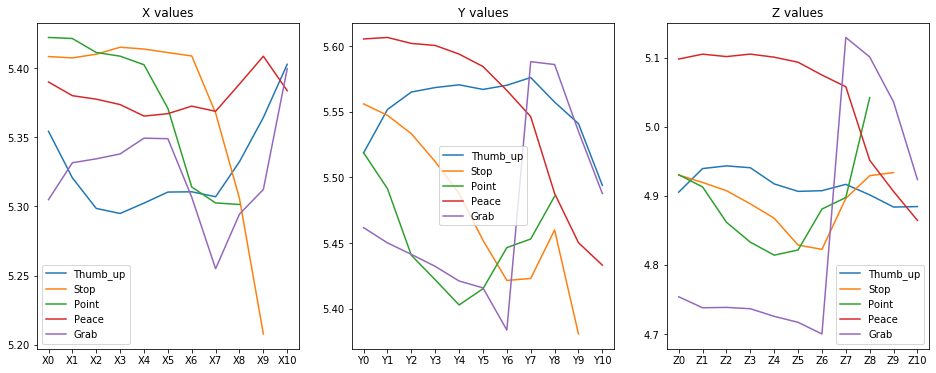

In [17]:
plt.figure(figsize=(16,6))

plt.subplot(1,3,1)
plt.plot(x_df)
plt.title('X values')
plt.legend(rename)

plt.subplot(1,3,2)
plt.plot(y_df)
plt.title('Y values')
plt.legend(rename)

plt.subplot(1,3,3)
plt.plot(z_df)
plt.title('Z values')
plt.legend(rename)

plt.show()

c:\python\python37\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
c:\python\python37\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

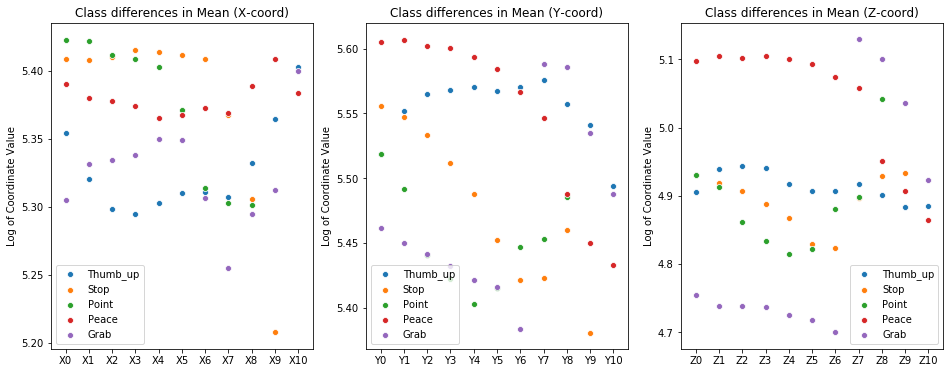

In [18]:
plt.figure(figsize=(16,6))

for i in x_df.columns:
    plt.subplot(1,3,1)
    sns.scatterplot(x=x_df.index, y=x_df[i], data=x_df)
    plt.legend(rename, loc='lower left')
    plt.ylabel('Log of Coordinate Value')
    plt.title('Class differences in Mean (X-coord)')
#plt.show()
    
for i in y_df.columns:
    plt.subplot(1,3,2)
    sns.scatterplot(x=y_df.index, y=y_df[i], data=y_df)
    plt.legend(rename, loc='lower left')
    plt.ylabel('Log of Coordinate Value')
    plt.title('Class differences in Mean (Y-coord)')
#plt.show()
    
    
for i in z_df.columns:
    plt.subplot(1,3,3)
    sns.scatterplot(x=z_df.index, y=z_df[i], data=z_df)
    plt.legend(rename, loc='lower right')
    plt.ylabel('Log of Coordinate Value')
    plt.title('Class differences in Mean (Z-coord)')
plt.show()

We can examine the data we have to see if there are any highly correlated features. Below we create a correlation matrix to do so. We can see from the visualization that there are many features which are either positively or negatively correlated with each other. We can try to combine some of these features. We will do so below to create a second set of data that we will later evaluate on our models.

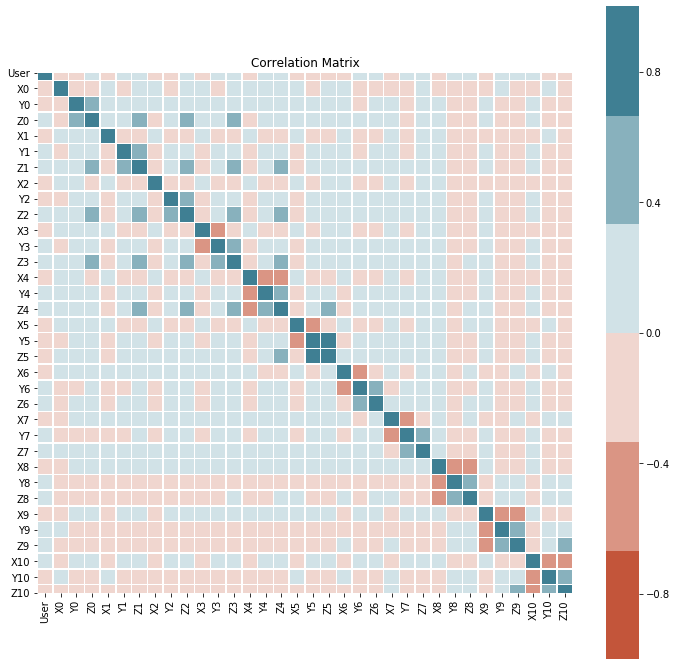

In [19]:
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(
    df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=.5).set_title('Correlation Matrix')

In [20]:
#finding features with atleast 65% correlation in either direction 
corr_matrix = df.corr().abs()

for col in col_names:
    data = corr_matrix[corr_matrix[col] > 0.65]
    if len(data) > 1:
        print('--------')
        print('variable: '+str(col))
        print('correlated with: ' +str(data.index))
    else:
        pass

--------
variable: Y3
correlated with: Index(['Y3', 'Z3'], dtype='object')
--------
variable: Y4
correlated with: Index(['Y4', 'Z4'], dtype='object')
--------
variable: Y5
correlated with: Index(['Y5', 'Z5'], dtype='object')
--------
variable: Y6
correlated with: Index(['Y6', 'Z6'], dtype='object')
--------
variable: Z3
correlated with: Index(['Y3', 'Z3'], dtype='object')
--------
variable: Z4
correlated with: Index(['Y4', 'Z4'], dtype='object')
--------
variable: Z5
correlated with: Index(['Y5', 'Z5'], dtype='object')
--------
variable: Z6
correlated with: Index(['Y6', 'Z6'], dtype='object')


Using the information above we can build new features based on these correlations. We do so below. Once we engineer a new feature we will drop the components that were combined for that feature. 

In [21]:
df2 = pd.DataFrame()
df2 = df.copy()

#Combining features with 65% or more correlation into new features
df2['Y_Z_3'] = df['Y3'] * df['Z3']
df2['Y_Z_4'] = df['Y4'] * df['Z4']
df2['Y_Z_5'] = df['Y5'] * df['Z5']
df2['Y_Z_6'] = df['Y6'] * df['Z6']


#dropping features that were used in a combined feature
df2.drop(['Y3', 'Z3', 'Y4', 'Z4', 'Y5', 'Z5', 'Y6', 'Z6'], axis=1, inplace=True)

# Splitting Data

In [22]:
#Split based on log transformed data
df_nona = df.fillna(0)

X = df_nona.drop('Class', axis=1)
y = df_nona['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=42)

In [23]:
#Split based on log transformed and feature engineered data
df2_nona = df2.fillna(0)

X2 = df2_nona.drop('Class', axis=1)
y2 = df2_nona['Class']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, train_size=.8, random_state=42)

In [24]:
#Initializing lists to track performance metrics
model = []
data_set = []
score = []
run_times = []
cv_range = []
sensitivity = []
specificity = []
mean_sensitivity = []
mean_specificity = []

In [25]:
#defining a function for automating sensitivity and specificity calculations for later
def matrix_breakdown(cm):
    for i in range (5):
        TP = cm[i,i]
        FP = cm[i].sum() - TP
        FN = cm[:,i].sum() - TP
        TN = cm.sum() - FP - FN - TP
        sens = TP / (TP+FN)
        spec = TN / (TN+FP)
        sensitivity.append(sens)
        specificity.append(spec)
        print(rename[i])
        print('sensitivity: '+str(sens))
        print('specificity: '+str(spec))
        print('-----')
    mean_spec = statistics.mean(specificity[-5:])
    mean_sens = statistics.mean(sensitivity[-5:])
    mean_sensitivity.append(mean_sens)
    mean_specificity.append(mean_spec)
    print('mean sensitivity: ' +str(mean_sens))
    print('mean specificity: ' +str(mean_spec))

# Training Models

**KNN**

In [26]:
# knn_p = [1, 2]
# knn_weights = ['uniform', 'distance']
# knn_neighbors = [5, 10, 25, 50, 100, 200]

# tuned_params = [{'n_neighbors': knn_neighbors, 'weights': knn_weights, 'p': knn_p}]
# n_folds=10

In [27]:
# #Finding optimal model parameters using Gridsearch on training data (original feature set)
# grid = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_params, cv=n_folds, refit=False)
# grid.fit(X_train, y_train)
# grid.best_params_

In [28]:
# #Finding optimal model parameters using Gridsearch on training data (engineered feature set)
# grid = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_params, cv=n_folds, refit=False)
# grid.fit(X_train_2, y_train_2)
# grid.best_params_

In [29]:
# #Finding optimal model parameters using Gridsearch on training data (engineered feature set)
# grid = GridSearchCV(KNeighborsClassifier(), param_grid=tuned_params, cv=n_folds, refit=False)
# grid.fit(X_train_3, y_train_3)
# grid.best_params_

In [30]:
X_data = [X_train, X_train_2, X_test, X_test_2]
y_data = [y_train, y_train_2, y_test, y_test_2]

for i in range(2):
    
    #running the model 
    start_time = time.time()
    neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
    neighbors.fit(X_data[i], y_data[i])
    y_pred = neighbors.predict(X_data[i+2])
    end_time = time.time()
    
    #evaluating performance
    cm = confusion_matrix(y_data[i+2], y_pred)
    cv_scores = cross_val_score(neighbors, X_data[i+2], y_data[i+2], cv=10)
    
    #appending metrics
    model.append('KNN')
    data_set.append(i) 
    score.append(cv_scores.mean())
    run_times.append(end_time-start_time)
    cv_range.append(cv_scores.max()-cv_scores.min())
    
    #displaying model results
    print('data set: '+str(i))
    print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
    print('mean cv score: ' + str(cv_scores.mean()))
    print('time to complete: '+str(end_time-start_time))
    print('confusion matrix:')
    print(cm)
    print('-----')
    matrix_breakdown(cm)
    print('\n')

data set: 0
range cv scores: 0.024619840695148443
mean cv score: 0.9658233837870698
time to complete: 5.699768543243408
confusion matrix:
[[2737   13    3   34    1]
 [   1 2533   26    2    5]
 [   1   69 2786    0   17]
 [  11   16    1 2615    5]
 [   0    0    3    8 2923]]
-----
Thumb_up
sensitivity: 0.9952727272727273
specificity: 0.9953887884267631
-----
Stop
sensitivity: 0.9627518053971874
specificity: 0.9969585830575186
-----
Point
sensitivity: 0.9882937211777226
specificity: 0.9920844327176781
-----
Peace
sensitivity: 0.9834524257239564
specificity: 0.9970406241592682
-----
Grab
sensitivity: 0.9905116909522196
specificity: 0.9989870153789483
-----
mean sensitivity: 0.9840564741047627
mean specificity: 0.9960918887480352


data set: 1
range cv scores: 0.02603763288522276
mean cv score: 0.9459813960223524
time to complete: 3.4198760986328125
confusion matrix:
[[2688   31    8   61    0]
 [   6 2494   52    6    9]
 [   2   64 2788    0   19]
 [  29   25    4 2586    4]
 [   0  

**Naive Bayes Models**

In [31]:
nb_models = [ComplementNB(), GaussianNB(), MultinomialNB(), BernoulliNB()]
nb_names = ['ComplimentNB', 'GaussianNB', 'MultinomialNB', 'BernoulliNB']

In [32]:
name = 0

for j in nb_models:
    for i in range(2):
        #running the model
        start_time = time.time()
        nb_model = j
        nb_model.fit(X_data[i], y_data[i])
        y_pred = nb_model.predict(X_data[i+2])
        end_time = time.time()
        
        #evaluating performance
        cm = confusion_matrix(y_data[i+2], y_pred)
        cv_scores = cross_val_score(nb_model, X_data[i+2], y_data[i+2], cv=10)
        
        #appending metrics
        model.append(nb_names[math.floor(name)])
        data_set.append(i)
        score.append(cv_scores.mean())
        run_times.append(end_time-start_time)
        cv_range.append(cv_scores.max()-cv_scores.min())
        
        #displaying model results
        print('model: '+nb_names[math.floor(name)])
        print('data set: '+str(i))
        print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
        print('mean cv score: ' + str(cv_scores.mean()))
        print('time to complete: '+str(end_time-start_time))
        print('confusion matrix:')
        print(cm)
        print('-----')
        matrix_breakdown(cm)
        print('\n')
        name += .335
        

model: ComplimentNB
data set: 0
range cv scores: 0.025653117042346518
mean cv score: 0.4769771509018432
time to complete: 0.12665963172912598
confusion matrix:
[[ 575  224    9 1865  115]
 [ 433  713  104    4 1313]
 [  11  680   80    0 2102]
 [ 181   26    3 2389   49]
 [   0    0   38    8 2888]]
-----
Thumb_up
sensitivity: 0.4791666666666667
specificity: 0.8245043616177636
-----
Stop
sensitivity: 0.4339622641509434
specificity: 0.8476206131338867
-----
Point
sensitivity: 0.3418803418803419
specificity: 0.7942692987625221
-----
Peace
sensitivity: 0.5600093764650727
specificity: 0.9728625314333613
-----
Grab
sensitivity: 0.4465749188186176
specificity: 0.993735530437151
-----
mean sensitivity: 0.45231871359632847
mean specificity: 0.8865984670769369


model: ComplimentNB
data set: 1
range cv scores: 0.022783374300085868
mean cv score: 0.4994910186564132
time to complete: 0.12267088890075684
confusion matrix:
[[ 575  298    4 1865   46]
 [ 433 1518  209    4  403]
 [  11 1190   31    

c:\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


model: MultinomialNB
data set: 1
range cv scores: 0.026030368763557465
mean cv score: 0.5739304338371999
time to complete: 0.14162087440490723
confusion matrix:
[[1809  305    0  631   43]
 [ 437 1891    0    0  239]
 [  11 1238    0    0 1624]
 [ 749   39    0 1821   39]
 [   0  521    0    8 2405]]
-----
Thumb_up
sensitivity: 0.6017964071856288
specificity: 0.9093854128100703
-----
Stop
sensitivity: 0.47346019028542813
specificity: 0.9311328443357784
-----
Point
sensitivity: nan
specificity: 0.7919623461259957
-----
Peace
sensitivity: 0.7402439024390244
specificity: 0.927136563876652
-----
Grab
sensitivity: 0.5528735632183908
specificity: 0.9440803382663848
-----
mean sensitivity: nan
mean specificity: 0.9007395010829763




c:\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


**Decision Tree**

In [33]:
# dtree_crit = ['gini', 'entropy']
# dtree_feat = [2, 4, 6, None, 'sqrt', 'log2']
# dtree_depth = [2, 4, 6, 8, 10, None]

# #refit=False??
# tuned_params = [{'criterion': dtree_crit ,
#                 'max_features': dtree_feat,
#                 'max_depth': dtree_depth}]

# n_folds=10

# grid = GridSearchCV(tree.DecisionTreeClassifier(), tuned_params, cv=n_folds, refit=False)
# grid.fit(X_train, y_train)
# grid.best_params_

In [34]:
# dtree_crit = ['gini', 'entropy']
# dtree_feat = [2, 4, 6, None, 'sqrt', 'log2']
# dtree_depth = [2, 4, 6, 8, 10, None]

# #refit=False??
# tuned_params = [{'criterion': dtree_crit ,
#                 'max_features': dtree_feat,
#                 'max_depth': dtree_depth}]

# n_folds=10

# grid = GridSearchCV(tree.DecisionTreeClassifier(), tuned_params, cv=n_folds, refit=False)
# grid.fit(X_train_2, y_train_2)
# grid.best_params_

In [35]:
for i in range(2):
    
    #running the model 
    start_time = time.time()
    dtree = tree.DecisionTreeClassifier(criterion='entropy', 
                                        max_features=None, 
                                        max_depth=None)
    dtree.fit(X_data[i], y_data[i])
    y_pred = dtree.predict(X_data[i+2])
    end_time = time.time()
    
    #evaluating performance
    cm = confusion_matrix(y_data[i+2], y_pred)
    cv_scores = cross_val_score(dtree, X_data[i+2], y_data[i+2], cv=10)
    
    #appending metrics
    model.append('Dec Tree')
    data_set.append(i) 
    score.append(cv_scores.mean())
    run_times.append(end_time-start_time)
    cv_range.append(cv_scores.max()-cv_scores.min())
    
    #displaying model results
    print('data set: '+str(i))
    print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
    print('mean cv score: ' + str(cv_scores.mean()))
    print('time to complete: '+str(end_time-start_time))
    print('confusion matrix:')
    print(cm)        
    print('-----')
    matrix_breakdown(cm)
    print('\n')

data set: 0
range cv scores: 0.016804360232010485
mean cv score: 0.9393898554357353
time to complete: 3.083767890930176
confusion matrix:
[[2665   18   14   88    3]
 [  24 2476   54   10    3]
 [  11   39 2809    6    8]
 [  82   20    3 2537    6]
 [   0    2    7    8 2917]]
-----
Thumb_up
sensitivity: 0.9579439252336449
specificity: 0.9888465723612623
-----
Stop
sensitivity: 0.9690802348336595
specificity: 0.9919147045757442
-----
Point
sensitivity: 0.9729823346033946
specificity: 0.9941408038084775
-----
Peace
sensitivity: 0.9577198942997357
specificity: 0.9900546546008422
-----
Grab
sensitivity: 0.993190330268982
specificity: 0.9984364940678746
-----
mean sensitivity: 0.9701833438478833
mean specificity: 0.9926786458828402


data set: 1
range cv scores: 0.02234069122158333
mean cv score: 0.9354822622091958
time to complete: 2.6260173320770264
confusion matrix:
[[2669   32   16   69    2]
 [  29 2443   81   14    0]
 [  23   53 2783    9    5]
 [  68   23    7 2544    6]
 [   3   

**Random Forest**

In [36]:
for i in range(2):
    #running the model 
    start_time = time.time()
    rfc = ensemble.RandomForestClassifier()
    rfc.fit(X_data[i], y_data[i])
    y_pred = rfc.predict(X_data[i+2])
    end_time = time.time()
    
    #evaluating performance
    cm = confusion_matrix(y_data[i+2], y_pred)
    cv_scores = cross_val_score(rfc, X_data[i+2], y_data[i+2], cv=10)
    
    #appending metrics
    model.append('Rand Forest')
    data_set.append(i) 
    score.append(cv_scores.mean())
    run_times.append(end_time-start_time)
    cv_range.append(cv_scores.max()-cv_scores.min())
    
    #displaying model results
    print('data set: '+str(i))
    print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
    print('mean cv score: ' + str(cv_scores.mean()))
    print('time to complete: '+str(end_time-start_time))
    print('confusion matrix:')
    print(cm)
    print('-----')
    matrix_breakdown(cm)
    print('\n')

c:\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data set: 0
range cv scores: 0.018826937002172306
mean cv score: 0.9640127840424191
time to complete: 1.970726728439331
confusion matrix:
[[2755    8    9   16    0]
 [   9 2513   43    2    0]
 [   2   17 2852    0    2]
 [  48   26   11 2560    3]
 [   0    0   10    8 2916]]
-----
Thumb_up
sensitivity: 0.9790334044065387
specificity: 0.9969989086940706
-----
Stop
sensitivity: 0.9801092043681747
specificity: 0.9951982927263027
-----
Point
sensitivity: 0.9750427350427351
specificity: 0.9980707395498393
-----
Peace
sensitivity: 0.9899458623356535
specificity: 0.99215965787598
-----
Grab
sensitivity: 0.9982882574460801
specificity: 0.9983469556433098
-----
mean sensitivity: 0.9844838927198364
mean specificity: 0.9961549108979004




c:\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


data set: 1
range cv scores: 0.020256797741607158
mean cv score: 0.9637215618051483
time to complete: 1.8809573650360107
confusion matrix:
[[2749    8   11   20    0]
 [   7 2518   37    2    3]
 [   3   24 2842    0    4]
 [  51   25    8 2561    3]
 [   0    0   10    8 2916]]
-----
Thumb_up
sensitivity: 0.9782918149466192
specificity: 0.9964545454545455
-----
Stop
sensitivity: 0.9778640776699029
specificity: 0.9956386292834891
-----
Point
sensitivity: 0.9773039889958735
specificity: 0.997156485048615
-----
Peace
sensitivity: 0.988421458896179
specificity: 0.9922452981549158
-----
Grab
sensitivity: 0.9965823650034177
specificity: 0.9983461962513782
-----
mean sensitivity: 0.9836927411023985
mean specificity: 0.9959682308385888




**Gradient Boosting Decision Trees**

In [37]:
for i in range(2):
    #running the model 
    start_time = time.time()
    clf = ensemble.GradientBoostingClassifier(n_estimators=100,
                                             max_depth=2,
                                             loss='deviance',
                                             learning_rate=.1)
    clf.fit(X_data[i], y_data[i])
    y_pred = clf.predict(X_data[i+2])
    end_time = time.time()
    
    #evaluating performance
    cm = confusion_matrix(y_data[i+2], y_pred)
    cv_scores = cross_val_score(clf, X_data[i+2], y_data[i+2], cv=10)
    
    #appending metrics
    model.append('Gboost dTrees')
    data_set.append(i) 
    score.append(cv_scores.mean())
    run_times.append(end_time-start_time)
    cv_range.append(cv_scores.max()-cv_scores.min())
    
    #displaying model results
    print('data set: '+str(i))
    print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
    print('mean cv score: ' + str(cv_scores.mean()))
    print('time to complete: '+str(end_time-start_time))
    print('confusion matrix:')
    print(cm)
    print('-----')
    matrix_breakdown(cm)
    print('\n')

data set: 0
range cv scores: 0.022377776379538195
mean cv score: 0.9525019396307138
time to complete: 40.695122957229614
confusion matrix:
[[2620   52   31   57   28]
 [  30 2450   70    7   10]
 [   3   61 2769    1   39]
 [  69   47   25 2499    8]
 [   0    0   12    8 2914]]
-----
Thumb_up
sensitivity: 0.9625275532696547
specificity: 0.9848484848484849
-----
Stop
sensitivity: 0.9386973180076629
specificity: 0.9895535714285715
-----
Point
sensitivity: 0.9525283797729618
specificity: 0.9904613409153444
-----
Peace
sensitivity: 0.9716174183514774
specificity: 0.9867414130628226
-----
Grab
sensitivity: 0.9716572190730244
specificity: 0.9981500323744334
-----
mean sensitivity: 0.9594055776949563
mean specificity: 0.9899509685259313


data set: 1
range cv scores: 0.027638249090258915
mean cv score: 0.9432288705620306
time to complete: 36.23004937171936
confusion matrix:
[[2599   78   48   51   12]
 [  46 2388  116    5   12]
 [   4   76 2744    1   48]
 [  81   47   28 2483    9]
 [   0 

**Logistic Regression**

In [38]:
for i in range(2):
    #running the model 
    start_time = time.time()
    logr = LogisticRegression(penalty='l1')
    logr.fit(X_data[i], y_data[i])
    y_pred = logr.predict(X_data[i+2])
    end_time = time.time()
    
    #evaluating performance
    cm = confusion_matrix(y_data[i+2], y_pred)
    cv_scores = cross_val_score(logr, X_data[i+2], y_data[i+2], cv=10)
    
    #appending metrics
    model.append('Logistic Reg')
    data_set.append(i) 
    score.append(cv_scores.mean())
    run_times.append(end_time-start_time)
    cv_range.append(cv_scores.max()-cv_scores.min())
    
    #displaying model results
    print('data set: '+str(i))
    print('range cv scores: ' +str(cv_scores.max()-cv_scores.min()))
    print('mean cv score: ' + str(cv_scores.mean()))
    print('time to complete: '+str(end_time-start_time))
    print('confusion matrix:')
    print(cm)
    print('-----')
    matrix_breakdown(cm)
    print('\n')

c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_clas

data set: 0
range cv scores: 0.03910209992758873
mean cv score: 0.7967394810324946
time to complete: 360.1672704219818
confusion matrix:
[[2133  196   53  369   37]
 [ 141 1840  427   27  132]
 [   5  476 2109    2  281]
 [ 296   17   28 2265   42]
 [   0   36  168    8 2722]]
-----
Thumb_up
sensitivity: 0.8283495145631068
specificity: 0.9417000445037829
-----
Stop
sensitivity: 0.7173489278752436
specificity: 0.9353490440195642
-----
Point
sensitivity: 0.7572710951526033
specificity: 0.930702947845805
-----
Peace
sensitivity: 0.847997004867091
specificity: 0.965616303079271
-----
Grab
sensitivity: 0.8469197261978842
specificity: 0.979992449981125
-----
mean sensitivity: 0.7995772537311858
mean specificity: 0.9506721578859096




c:\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence 

data set: 1
range cv scores: 0.04578755155369452
mean cv score: 0.7923200205380071
time to complete: 332.36363410949707
confusion matrix:
[[2156  184   89  327   32]
 [ 159 1862  418   11  117]
 [   9  537 2060    0  267]
 [ 294   20   23 2270   41]
 [   0   24  187    8 2715]]
-----
Thumb_up
sensitivity: 0.8235294117647058
specificity: 0.9435310936383131
-----
Stop
sensitivity: 0.7087933003425961
specificity: 0.9369578825002236
-----
Point
sensitivity: 0.7418077061577242
specificity: 0.9263119731713949
-----
Peace
sensitivity: 0.867737003058104
specificity: 0.9662319099517599
-----
Grab
sensitivity: 0.8559268600252207
specificity: 0.9794134235758601
-----
mean sensitivity: 0.7995588562696702
mean specificity: 0.9504892565675104




c:\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Evaluation

In [39]:
comparison_df = pd.DataFrame()

comparison_df['model'] = model
comparison_df['data_set'] = data_set
comparison_df['score'] = score
comparison_df['run_times'] = run_times
comparison_df['cv_range'] = cv_range
comparison_df['score/time'] = comparison_df['score'] / comparison_df['run_times']
comparison_df['Mean Sensitivity'] = mean_sensitivity
comparison_df['Mean Specificity'] = mean_specificity


comparison_df.sort_values(by='score', ascending=False)

,model,data_set,score,run_times,cv_range,score/time,Mean Sensitivity,Mean Specificity
0,KNN,0,0.965823,5.699769,0.024620,0.169450,0.984056,0.996092
12,Rand Forest,0,0.964013,1.970727,0.018827,0.489166,0.984484,0.996155
13,Rand Forest,1,0.963722,1.880957,0.020257,0.512357,0.983693,0.995968
14,Gboost dTrees,0,0.952502,40.695123,0.022378,0.023406,0.959406,0.989951
1,KNN,1,0.945981,3.419876,0.026038,0.276613,0.975469,0.993988
15,Gboost dTrees,1,0.943229,36.230049,0.027638,0.026034,0.949748,0.987499
10,Dec Tree,0,0.939390,3.083768,0.016804,0.304624,0.970183,0.992679
11,Dec Tree,1,0.935482,2.626017,0.022341,0.356236,0.966255,0.991702
16,Logistic Reg,0,0.796739,360.167270,0.039102,0.002212,0.799577,0.950672
17,Logistic Reg,1,0.792320,332.363634,0.045788,0.002384,0.799559,0.950489


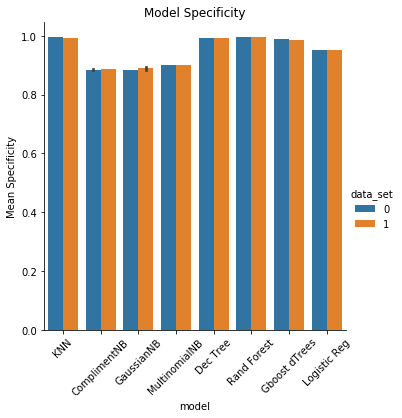

In [40]:
g = sns.catplot(x='model', y='Mean Specificity', hue='data_set', data=comparison_df, kind='bar')
g.set_xticklabels(rotation=45)
plt.title('Model Specificity')


plt.show()

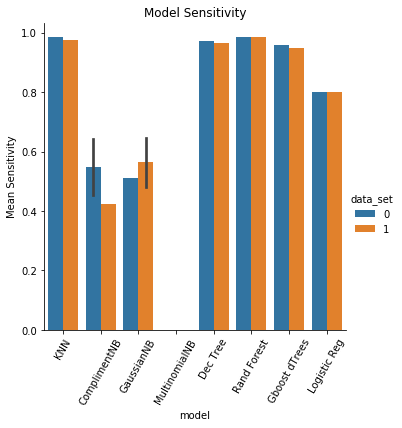

In [41]:
g = sns.catplot(x='model', y='Mean Sensitivity', hue='data_set', data=comparison_df, kind='bar')
g.set_xticklabels(rotation=60)
plt.title('Model Sensitivity')

plt.show()

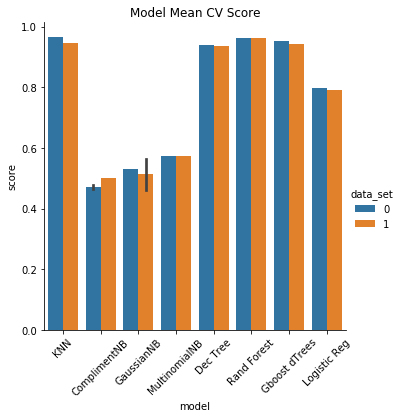

In [42]:
g = sns.catplot(x='model', y='score', hue='data_set', data=comparison_df, kind='bar')
g.set_xticklabels(rotation=45)
plt.title('Model Mean CV Score')

plt.show()

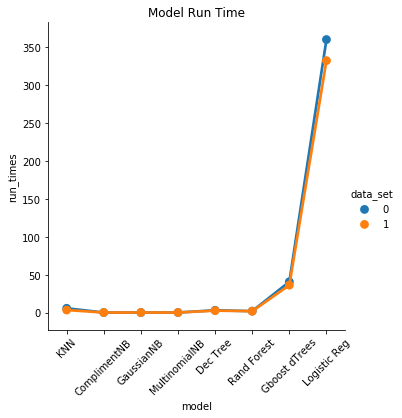

In [43]:
g = sns.catplot(x='model', y='run_times', hue='data_set', data=comparison_df, kind='point')
g.set_xticklabels(rotation=45)
plt.title('Model Run Time')

plt.show()

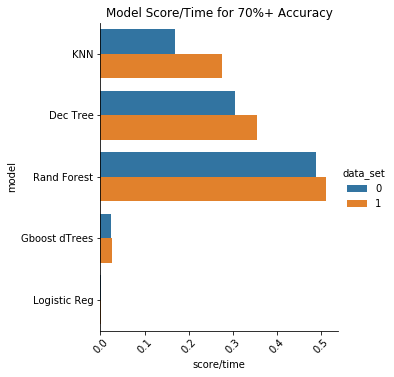

In [44]:
#Comparing the models that have at least 70% accuracy
model_eff = comparison_df[comparison_df['score']>.70]

g = sns.catplot(x='score/time', y='model', hue='data_set', data=model_eff, kind='bar')
g.set_xticklabels(rotation=45)
plt.title('Model Score/Time for 70%+ Accuracy')

plt.show()

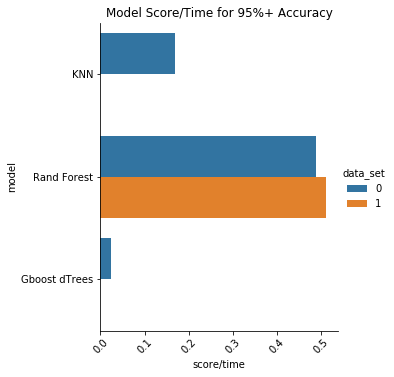

In [45]:
#Comparing the models that have at least 95% accuracy
model_eff = comparison_df[comparison_df['score']>.95]

g = sns.catplot(x='score/time', y='model', hue='data_set', data=model_eff, kind='bar')
g.set_xticklabels(rotation=45)
plt.title('Model Score/Time for 95%+ Accuracy')


plt.show()

Based on this comparison we can see that the model that we should select for our task is Random Forest, using the feature engineered dataset. 